In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import cv2
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_data(data_dir):
    X = []
    y = []
    for label_dir in glob(data_dir + "/*"):
        if label_dir.split("\\")[1] == "NORMAL":
            label = 0
        else:
            label = 1
        for image_file in tqdm(glob(label_dir + "/*.jp*g")):
            img_file = cv2.imread(image_file)
            if img_file is not None:
                img_array = np.asarray(cv2.resize(img_file, (224, 224)))
                X.append(img_array)
                y.append(label)
        
    return np.asarray(X), np.asarray(y)

X_train, y_train = get_data("./chest_xray/chest_xray/train")
X_test, y_test = get_data("./chest_xray/chest_xray/test")

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:03<00:00, 97.59it/s]


X_train shape:  (5216, 224, 224, 3)
X_test shape:  (624, 224, 224, 3)
y_train shape:  (5216, 2)
y_test shape:  (624, 2)


In [3]:
rus = RandomUnderSampler(sampling_strategy="auto")
X_train1, y_train1 = rus.fit_sample(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
y_train = to_categorical(y_train, num_classes=2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (5216, 224, 224, 3)
X_test shape:  (624, 224, 224, 3)
y_train shape:  (5216, 2, 2)
y_test shape:  (624, 2)


In [4]:
def keras_model(block_num=2):
    inp = Input(shape=(224, 224, 3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        k = x
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    y = Dense(2,activation="sigmoid")(x)
    model = Model(inp, y)
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [5]:
model = keras_model(4)
model.load_weights("weights_pneumonia.hdf5")

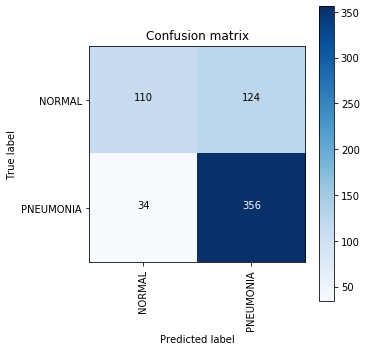

In [6]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

y_predictions = np.argmax(model.predict(np.asarray(X_test, dtype=np.float32)), axis=1)
y_true = np.argmax(y_test, axis=1)

    
cm = confusion_matrix(y_true, y_predictions) 
plot_confusion_matrix(cm, classes=["NORMAL", "PNEUMONIA"])

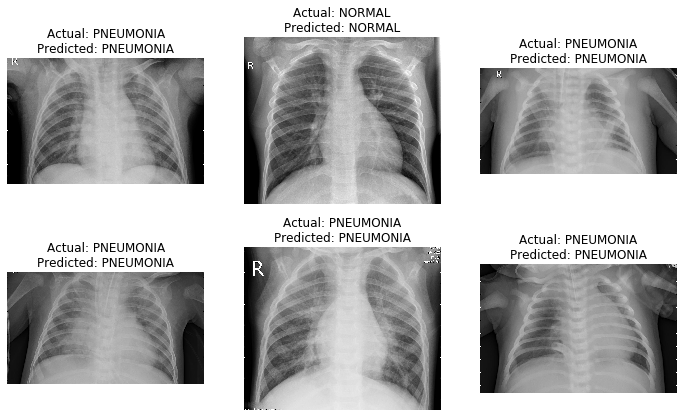

In [25]:
def plotSampleResults():
    labels_dict = {0: "NORMAL", 1: "PNEUMONIA"}
    image_files = glob("chest_xray/test/*/*.jp*g")
    plt.figure(figsize=(12, 7))
    random_images_indices = np.random.randint(1, len(X_test), 6)
    count = 0
    for i in random_images_indices:
        count += 1
        image = cv2.imread(image_files[i])
        plt.subplot(2, 3, count)
        plt.imshow(image)
        plt.title("Actual: " + image_files[i].split("\\")[-2] + "\nPredicted: " + labels_dict[y_predictions[i]])
        plt.axis("off")

plotSampleResults()